# Lab 3

In this lab, you will fit first order plus time delay (FOPTD) and second order plus time delay (SOPTD) models to experimental data using graphical methods.

# Exercise 1

The Q1/T1 system can be approximated fairly well by a first-order model. 

A first-order model of the Temperature Control Lab has the form:

$$\tau_p \frac{dT'}{dt} = -T' + K_pQ'(t - \theta_p) $$

where $T' = T - T_{ss}$ and $Q'=Q - Q_{ss}$ are deviation variables with steady-state initial conditions. Perform a step test with heater 1 starting at 0% for 5 minutes and then step the heater up to 70% for 7.5 minutes. Create a plot of the temperature response over 8 minutes that also shows the heater level (%). 

You may use the sample source code in `fotd.py` as a starting point.



Step test data are convenient for identifying a FOPTD model through a graphical fitting method. Create an interactive plot with the `ipywidgets` to vary the process gain, time constant, and time delay until you find a good fit.

After you have found the model parameters, use the formal graphical method for determining the model parameters:

1. Find $\Delta y$ from step response.
2. Find $\Delta u$ from step response.
3. Calculate $K_p = \frac{\Delta y}{\Delta u}$
4. Find $\theta$, apparent dead time, from step response
5. Find $0.632\Delta y$ from step response
6. Find $t_{0.632}$ for $y(t_{0.632})=0.632\Delta y$ from step response
7. Calculate $\tau = t_{0.632} - \theta$. This assumes the step starts at $t=0$. If the step happens later, subtract the step time as well.

Compare the two.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import tclab
import time
import ipywidgets as wg
from IPython.display import display 
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d

n = 480  # Number of second time points (8 min)
tm = np.linspace(0,n,n+1) # Time values

# data

lab = tclab.TCLab()
T1 = [lab.T1]
Q1 = np.zeros(n+1)
Q1[30:] = 70.0
for i in range(n):
    lab.Q1(Q1[i])
    time.sleep(1)
    print(lab.T1)
    T1.append(lab.T1)
lab.close()


TCLab version 0.4.9
Arduino Leonardo connected on port COM3 at 115200 baud.
TCLab Firmware 3.0.0 Arduino Leonardo/Micro.
24.121
24.121
24.121
24.121
24.121
24.057
24.121
24.153
24.121
24.153
24.121
24.121
24.121
24.121
24.153
24.186
24.121
24.121
24.153
24.121
24.121
24.153
24.153
24.153
24.121
24.153
24.25
24.218
24.218
24.379
24.508
24.476
24.572
24.604
24.572
24.637
24.637
24.701
24.959
24.895
25.12
25.249
25.346
25.539
25.732
25.894
25.958
26.248
26.538
26.603
26.893
27.183
27.247
27.537
27.698
27.795
28.053
28.149
28.504
28.697
28.987
29.116
29.471
29.632
29.986
30.115
30.405
30.695
30.792
31.114
31.34
31.63
31.694
32.049
32.21
32.403
32.726
32.919
33.016
33.338
33.467
33.66
33.918
34.047
34.305
34.434
34.659
34.981
35.046
35.207
35.626
35.852
36.045
36.238
36.464
36.561
36.851
37.076
37.141
37.302
37.527
37.56
37.785
37.85
38.107
38.236
38.397
38.752
38.816
39.171
39.396
39.396
39.654
39.815
39.977
40.428
40.46
40.718
40.911
41.04
41.201
41.459
41.556
41.717
41.749
41.975
42.168


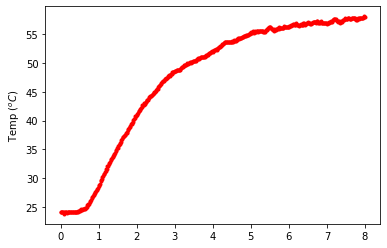

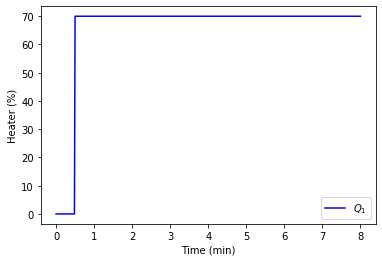

In [14]:

plt.figure(1)
plt.plot(tm/60.0,T1,'r.',label=r'$T_1$')
plt.ylabel(r'Temp ($^oC$)')
plt.figure(2)
plt.plot(tm/60.0,Q1,'b-',label=r'$Q_1$')
plt.ylabel(r'Heater (%)')
plt.xlabel('Time (min)')
plt.legend()
plt.savefig('Step_Response.png')
plt.show()
    

In [32]:
def sim_model(Km,taum,thetam):
    # input arguments
    #Km
    #taum
    #thetam
    # storage for model values
    ym = np.zeros(ns+1)  # model
    # initial condition
    ym[0] = 0
    # loop through time steps    
    for i in range(1,ns+1):
        ts = [delta_t*(i-1),delta_t*i]
        y1 = odeint(fopdt,ym[i-1],ts,args=(uf,Km,taum,thetam))
        ym[i] = y1[-1]
    return ym  
    
    plt.figure(1)
    plt.plot(tm/60.0,T1,'r.',label=r'$T_1$')
    plt.ylabel(r'Temp ($^oC$)')
    
    plt.plot(ym,t)

In [33]:
K_slide = wg.FloatSlider(value=4.0,min=-10.0,max=10.0,step=0.1)
tau_slide = wg.FloatSlider(value=1.0,min=0.1,max=10.0,step=0.1)
theta_slide = wg.FloatSlider(value=2.0,min=0.1,max=15.0,step=0.1)
wg.interact(fopdtPlot, K=K_slide, tau=tau_slide, theta=theta_slide)

interactive(children=(FloatSlider(value=4.0, description='K', max=10.0, min=-10.0), FloatSlider(value=1.0, des…

<function __main__.fopdtPlot(K, tau, theta)>

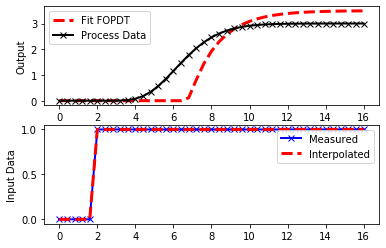

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d

# define process model (to generate process data)
def process(y,t,n,u,Kp,taup):
    # arguments
    #  y[n] = outputs
    #  t    = time
    #  n    = order of the system  
    #  u    = input value
    #  Kp   = process gain
    #  taup = process time constant

    # equations for higher order system
    dydt = np.zeros(n)
    # calculate derivative
    dydt[0] = (-y[0] + Kp * u)/(taup/n)
    for i in range(1,n):
       dydt[i] = (-y[i] + y[i-1])/(taup/n)
    return dydt

# define first-order plus dead-time approximation    
def fopdt(y,t,uf,Km,taum,thetam):
    # arguments
    #  y      = output
    #  t      = time
    #  uf     = input linear function (for time shift)
    #  Km     = model gain
    #  taum   = model time constant
    #  thetam = model time constant
    # time-shift u
    try:
        if (t-thetam) <= 0:
            um = uf(0.0)
        else:
            um = uf(t-thetam)
    except:
        #print('Error with time extrapolation: ' + str(t))
        um = 0
    # calculate derivative
    dydt = (-y + Km * um)/taum
    return dydt

# specify number of steps
ns = 40
# define time points
t = np.linspace(0,16,ns+1)
delta_t = t[1]-t[0]
# define input vector
u = np.zeros(ns+1)
u[5:] = 1.0
# create linear interpolation of the u data versus time
uf = interp1d(t,u)

# use this function or replace yp with real process data
def sim_process_data():
    plt.figure(1)
    plt.plot(tm/60.0,T1,'r.',label=r'$T_1$')
    plt.ylabel(r'Temp ($^oC$)')
    plt.figure(2)
    plt.plot(tm/60.0,Q1,'b-',label=r'$Q_1$')
    plt.ylabel(r'Heater (%)')
    plt.xlabel('Time (min)')
    plt.legend()
    plt.savefig('Step_Response.png')
    plt.show()

# simulate FOPDT model with x=[Km,taum,thetam]
def sim_model(Km,taum,thetam):
    # input arguments
    #Km
    #taum
    #thetam
    # storage for model values
    ym = np.zeros(ns+1)  # model
    # initial condition
    ym[0] = 0
    # loop through time steps    
    for i in range(1,ns+1):
        ts = [delta_t*(i-1),delta_t*i]
        y1 = odeint(fopdt,ym[i-1],ts,args=(uf,Km,taum,thetam))
        ym[i] = y1[-1]
    return ym    

# calculate model with updated parameters
Km = 3.5
taum = 1.5
thetam = 5.0
ym = sim_model(Km,taum,thetam)

# plot results
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,ym,'r--',linewidth=3,label='Fit FOPDT')
plt.plot(t,yp,'kx-',linewidth=2,label='Process Data')
plt.ylabel('Output')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(t,u,'bx-',linewidth=2)
plt.plot(t,uf(t),'r--',linewidth=3)
plt.legend(['Measured','Interpolated'],loc='best')
plt.ylabel('Input Data')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tclab
import time
n = 480  # Number of second time points (8 min)
tm = np.linspace(0,n,n+1) # Time values# 
datalab = tclab.TCLab()
T1 = [lab.T1]
T2 = [lab.T2]
Q1 = np.zeros(n+1)
Q2 = np.zeros(n+1)
Q1[30:] = 70.0# Create Figure
plt.figure(figsize=(12,8))
plt.ion()
plt.show()
for i in range(n):    
    lab.Q1(Q1[i])    
    time.sleep(1)    
    print(lab.T1)    
    T1.append(lab.T1)    
    T2.append(lab.T2)    
    plt.clf()    
    ax = plt.subplot(2,1,1)    
    ax.grid()    
    plt.plot(tm[0:i]/60.0,T1[0:i],'r.',label=r'$T_1$')    
    plt.plot(tm[0:i]/60.0,T2[0:i],'b.',label=r'$T_2$')    
    plt.ylabel(r'Temp ($^oC$)')    
    plt.legend()    
    ax = plt.subplot(2,1,2)    
    ax.grid()    
    plt.plot(tm[0:i]/60.0,Q1[0:i],'b-',label=r'$Q_1$')    
    plt.ylabel(r'Heater (%)')    
    plt.xlabel('Time (min)')    
    plt.legend()    
    #plt.savefig('Step_Response.png')    
    #plt.show()    
plt.draw()    
plt.pause(0.05)
plt.savefig('Step_Response.png')
lab.close()
def save_txt(t, u1, u2, y1, y2):    
    data = np.vstack((t, u1, u2, y1, y2))  # vertical stack    
    data = data.T  # transpose data    
    top = ('Time,Q1,Q2,T1,T2')    
    np.savetxt('foptd.txt', data, delimiter=',',\
               header=top, comments='')
    
save_txt(tm,Q1,Q2,T1,T2)

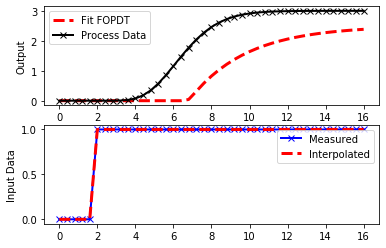

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d

# define process model (to generate process data)
def process(y,t,n,u,Kp,taup):
    # arguments
    #  y[n] = outputs
    #  t    = time
    #  n    = order of the system  
    #  u    = input value
    #  Kp   = process gain
    #  taup = process time constant

    # equations for higher order system
    dydt = np.zeros(n)
    # calculate derivative
    dydt[0] = (-y[0] + Kp * u)/(taup/n)
    for i in range(1,n):
       dydt[i] = (-y[i] + y[i-1])/(taup/n)
    return dydt

# define first-order plus dead-time approximation    
def fopdt(y,t,uf,Km,taum,thetam):
    # arguments
    #  y      = output
    #  t      = time
    #  uf     = input linear function (for time shift)
    #  Km     = model gain
    #  taum   = model time constant
    #  thetam = model time constant
    # time-shift u
    try:
        if (t-thetam) <= 0:
            um = uf(0.0)
        else:
            um = uf(t-thetam)
    except:
        #print('Error with time extrapolation: ' + str(t))
        um = 0
    # calculate derivative
    dydt = (-y + Km * um)/taum
    return dydt

# specify number of steps
ns = 40
# define time points
t = np.linspace(0,16,ns+1)
delta_t = t[1]-t[0]
# define input vector
u = np.zeros(ns+1)
u[5:] = 1.0
# create linear interpolation of the u data versus time
uf = interp1d(t,u)

# use this function or replace yp with real process data
def sim_process_data():
    # higher order process
    n=10       # order
    Kp=3.0    # gain
    taup=5.0   # time constant
    # storage for predictions or data
    yp = np.zeros(ns+1)  # process
    for i in range(1,ns+1):
        if i==1:
            yp0 = np.zeros(n)
        ts = [delta_t*(i-1),delta_t*i]
        y = odeint(process,yp0,ts,args=(n,u[i],Kp,taup))
        yp0 = y[-1]
        yp[i] = y[1][n-1]
    return yp
yp = sim_process_data()

# simulate FOPDT model with x=[Km,taum,thetam]
def sim_model(Km,taum,thetam):
    # input arguments
    #Km
    #taum
    #thetam
    # storage for model values
    ym = np.zeros(ns+1)  # model
    # initial condition
    ym[0] = 0
    # loop through time steps    
    for i in range(1,ns+1):
        ts = [delta_t*(i-1),delta_t*i]
        y1 = odeint(fopdt,ym[i-1],ts,args=(uf,Km,taum,thetam))
        ym[i] = y1[-1]
    return ym    

# calculate model with updated parameters
Km = 2.5
taum = 3.0
thetam = 5.0
ym = sim_model(Km,taum,thetam)

# plot results
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,ym,'r--',linewidth=3,label='Fit FOPDT')
plt.plot(t,yp,'kx-',linewidth=2,label='Process Data')
plt.ylabel('Output')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(t,u,'bx-',linewidth=2)
plt.plot(t,uf(t),'r--',linewidth=3)
plt.legend(['Measured','Interpolated'],loc='best')
plt.ylabel('Input Data')
plt.show()

# Exercise 2

The Q1/T2 system is better approximated as a second-order system.

A second-order model of the Temperature Control Lab has the form:

$$\tau_1 \tau_2 \frac{d^2T'}{dt^2} + (\tau_1 + \tau_2)\frac{dT'}{dt} = -T' + K_pQ'(t - \theta_p) $$

Using the step test data from above, create an interactive plot using `ipywidgets` to manually vary the model parameters until you obtain a good fit.

Use Smith's method (in section 7.2.1 of Seborg) to determine the two time constants for the second order model. Compare to the values you found manually.

Initial SSE Objective: 44.24242106770752
Final SSE Objective: 0.029303718249964816
Kp: 2.9875337217300886
taup: 1.5126317229944388
zeta: 0.8367124481978763
thetap: 2.0478014034524623


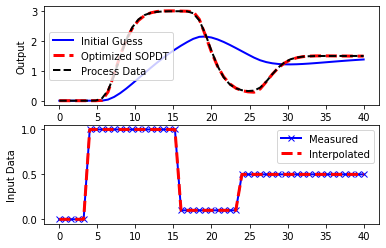

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import warnings

# Import CSV data file
# Column 1 = time (t)
# Column 2 = input (u)
# Column 3 = output (yp)
url = 'http://apmonitor.com/pdc/uploads/Main/data_fopdt.txt'
data = pd.read_csv(url)
t = data['time'].values - data['time'].values[0]
u = data['u'].values
yp = data['y'].values
u0 = u[0]
y0 = yp[0]
xp0 = yp[0]

# specify number of steps
ns = len(t)
delta_t = t[1]-t[0]
# create linear interpolation of the u data versus time
uf = interp1d(t,u)

def sopdt(x,t,uf,Kp,taus,zeta,thetap):
    # Kp = process gain
    # taus = second order time constant
    # zeta = damping factor
    # thetap = model time delay
    # ts^2 dy2/dt2 + 2 zeta taus dydt + y = Kp u(t-thetap)
    # time-shift u
    try:
        if (t-thetap) <= 0:
            um = uf(0.0)
        else:
            um = uf(t-thetap)
    except:
        # catch any error
        um = u0
    # two states (y and y')
    y = x[0] - y0
    dydt = x[1]
    dy2dt2 = (-2.0*zeta*taus*dydt - y + Kp*(um-u0))/taus**2
    return [dydt,dy2dt2]

# simulate model with x=[Km,taum,thetam]
def sim_model(x):
    # input arguments
    Kp = x[0]
    taus = x[1]
    zeta = x[2]
    thetap = x[3]
    # storage for model values
    xm = np.zeros((ns,2))  # model
    # initial condition
    xm[0] = xp0
    # loop through time steps    
    for i in range(0,ns-1):
        ts = [t[i],t[i+1]]
        inputs = (uf,Kp,taus,zeta,thetap)
        # turn off warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            # integrate SOPDT model
            x = odeint(sopdt,xm[i],ts,args=inputs)
        xm[i+1] = x[-1]
    y = xm[:,0]
    return y

# define objective
def objective(x):
    # simulate model
    ym = sim_model(x)
    # calculate objective
    obj = 0.0
    for i in range(len(ym)):
        obj = obj + (ym[i]-yp[i])**2    
    # return result
    return obj

# initial guesses
p0 = np.zeros(4)
p0[0] = 3 # Kp
p0[1] = 5.0 # taup
p0[2] = 1.0 # zeta
p0[3] = 2.0 # thetap

# show initial objective
print('Initial SSE Objective: ' + str(objective(p0)))

# optimize Kp, taus, zeta, thetap
solution = minimize(objective,p0)

# with bounds on variables
#no_bnd = (-1.0e10, 1.0e10)
#low_bnd = (0.01, 1.0e10)
#bnds = (no_bnd, low_bnd, low_bnd, low_bnd)
#solution = minimize(objective,p0,method='SLSQP',bounds=bnds)

p = solution.x

# show final objective
print('Final SSE Objective: ' + str(objective(p)))

print('Kp: ' + str(p[0]))
print('taup: ' + str(p[1]))
print('zeta: ' + str(p[2]))
print('thetap: ' + str(p[3]))

# calculate model with updated parameters
ym1 = sim_model(p0)
ym2 = sim_model(p)
# plot results
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,ym1,'b-',linewidth=2,label='Initial Guess')
plt.plot(t,ym2,'r--',linewidth=3,label='Optimized SOPDT')
plt.plot(t,yp,'k--',linewidth=2,label='Process Data')
plt.ylabel('Output')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(t,u,'bx-',linewidth=2)
plt.plot(t,uf(t),'r--',linewidth=3)
plt.legend(['Measured','Interpolated'],loc='best')
plt.ylabel('Input Data')
plt.savefig('results.png')
plt.show()

# Exercise 3

Repeat Exercises 1 and 2 with the Q2/T2 and Q2/T1 systems.